In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [335]:
vn30f_1min = pd.read_csv(r"../data/VN30F1M_1min_cleaned.csv",parse_dates=[0],index_col=0)
vn30_1min = pd.read_csv(r"../data/VN30_1min_cleaned.csv",parse_dates=[0],index_col=0)

In [336]:
vn30f_close = vn30f_1min[['close', 'days_to_maturity', 'day_of_week', 'is_morning']]
vn30_close = vn30_1min['close'].to_frame()
df = vn30_close.merge(vn30f_close, how='left', left_index=True, right_index=True,  suffixes=('_spot', '_future'))

In [337]:
df.head()

,close_spot,close_future,days_to_maturity,day_of_week,is_morning
2020-12-30 09:16:00,1059.88,1069.4,16,2,1
2020-12-30 09:17:00,1061.00,1069.1,16,2,1
2020-12-30 09:18:00,1061.40,1069.4,16,2,1
2020-12-30 09:19:00,1062.44,1069.6,16,2,1
2020-12-30 09:20:00,1062.43,1070.2,16,2,1


## Examining Distribution of Futures to Spot Price Ratio

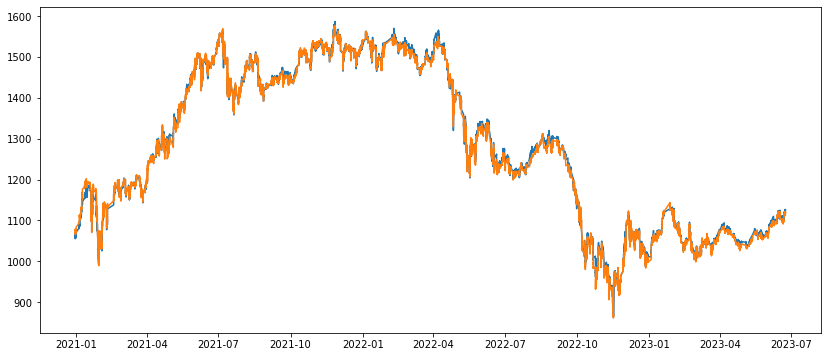

In [338]:
plt.figure(figsize=(14, 6))
plt.plot(df[["close_spot", "close_future"]])
plt.show()

In [339]:
df["future_to_spot"] = df["close_future"] / df["close_spot"]

In [340]:
print("Percent of times futures to spot ratio is greater than 1")
print(len(df[df["future_to_spot"] < 1]) / len(df))

Percent of times futures to spot ratio is greater than 1
0.667194962780224


In [341]:
df["future_to_spot"].describe()

count    139442.000000
mean          0.998054
std           0.005326
min           0.963103
25%           0.994986
50%           0.998270
75%           1.000909
max           1.039865
Name: future_to_spot, dtype: float64

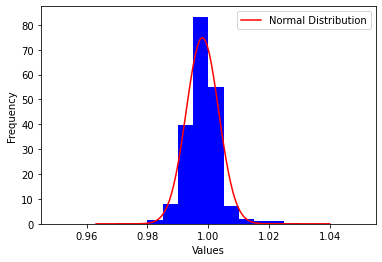

The distribution is not normal, the p-value is 0.0


/Users/nambuismbp/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [342]:
import scipy.stats as stats
from scipy.stats import norm

plt.hist(df["future_to_spot"], bins = 20, density=True, range = (0.95, 1.05), color='blue')

# Generate the normal distribution curve
x = np.linspace(np.min(df["future_to_spot"]), np.max(df["future_to_spot"]), 100)
y = norm.pdf(x, np.mean(df["future_to_spot"]), np.std(df["future_to_spot"]))

plt.plot(x, y, 'r-', label='Normal Distribution')
# Set labels and legend
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Shapiro-Wilk test
_, shapiro_pvalue = stats.shapiro(df["future_to_spot"])
if shapiro_pvalue < 0.05:
    print(f"The distribution is not normal, the p-value is {shapiro_pvalue}")

## Examining Changes in Futures to Spot Price Ratio at Maturity

<BarContainer object of 32 artists>

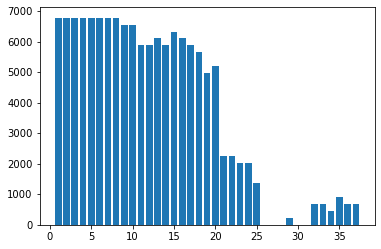

In [343]:
plt.bar(x=df["days_to_maturity"].value_counts().index, height=df["days_to_maturity"].value_counts().values)

In [344]:
maturity_groups = df.groupby(df["days_to_maturity"])

In [345]:
days_to_maturity = maturity_groups["future_to_spot"].mean().index
mean_future_to_spot = maturity_groups["future_to_spot"].mean().values
std_future_to_spot = maturity_groups["future_to_spot"].std().values

In [346]:
days_to_maturity[:20]

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64', name='days_to_maturity')

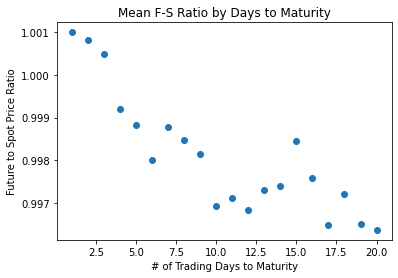

In [347]:
plt.scatter(days_to_maturity[:20], mean_future_to_spot[:20])
plt.ylabel("Future to Spot Price Ratio")
plt.xlabel("# of Trading Days to Maturity")
plt.title("Mean F-S Ratio by Days to Maturity")
plt.show()

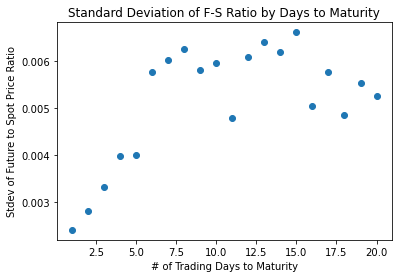

In [348]:
plt.scatter(days_to_maturity[:20], std_future_to_spot[:20])
plt.ylabel("Stdev of Future to Spot Price Ratio")
plt.xlabel("# of Trading Days to Maturity")
plt.title("Standard Deviation of F-S Ratio by Days to Maturity")
plt.show()

## Correlations between Changes in Spot and Futures Prices at Varying Maturity

In [349]:
df.head()

,close_spot,close_future,days_to_maturity,day_of_week,is_morning,future_to_spot
2020-12-30 09:16:00,1059.88,1069.4,16,2,1,1.008982
2020-12-30 09:17:00,1061.00,1069.1,16,2,1,1.007634
2020-12-30 09:18:00,1061.40,1069.4,16,2,1,1.007537
2020-12-30 09:19:00,1062.44,1069.6,16,2,1,1.006739
2020-12-30 09:20:00,1062.43,1070.2,16,2,1,1.007313


In [350]:
intervals = np.array(range(1, 11))
maturity_range = np.array(range(1, 21))

# A new dataframe with x-axis being days to maturity; y-axis being correlation of price changes at different interval
corr_df = pd.DataFrame(index = maturity_range)

In [351]:
for interval in intervals:
    corr_ls = []
    for day in maturity_range:
        group = df[df["days_to_maturity"] == day]
        spot_close_change = group.groupby(group.index.date)["close_spot"].pct_change(interval).dropna()
        future_close_change = group.groupby(group.index.date)["close_future"].pct_change(interval).dropna()
        corr = np.corrcoef(spot_close_change.values, future_close_change.values)
        corr_ls.append(corr[0][1])
    corr_df[str(interval)+ " min"] = corr_ls

In [352]:
corr_df.head()

,1 min,2 min,3 min,4 min,5 min,6 min,7 min,8 min,9 min,10 min
1,0.334837,0.523250,0.592746,0.632292,0.660834,0.687053,0.707604,0.725582,0.740513,0.753462
2,0.359905,0.527399,0.601081,0.650684,0.697469,0.730201,0.749897,0.765172,0.774840,0.782210
3,0.378108,0.548187,0.606426,0.641778,0.671692,0.689826,0.709053,0.723601,0.739719,0.752557
4,0.414357,0.575444,0.642996,0.686640,0.723241,0.748455,0.767973,0.784937,0.798191,0.808548
5,0.455980,0.603884,0.656954,0.695180,0.726974,0.742206,0.761366,0.776992,0.788368,0.799457


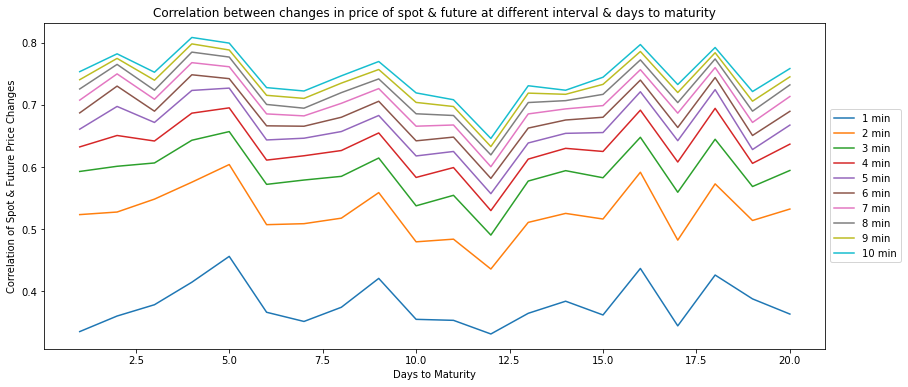

In [353]:
plt.figure(figsize=(14, 6))
for column in corr_df.columns:
    plt.plot(corr_df[column], label=column)

plt.xlabel("Days to Maturity")
plt.ylabel("Correlation of Spot & Future Price Changes")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Correlation between changes in price of spot & future at different interval & days to maturity")
plt.show()

## Examining Future to Spot Ratio with Other Time Characteristics

In [387]:
ratio_by_dayofweek = []
for i in range(0, 5):
    ratios = df[df["day_of_week"] == i]["future_to_spot"]
    ratio_by_dayofweek.append(ratios)
    print(f"Mean: {round(ratios.mean(), 5)}", f"; Stdev: {round(ratios.std(), 5)}")

Mean: 0.99792 ; Stdev: 0.00549
Mean: 0.99831 ; Stdev: 0.00532
Mean: 0.99823 ; Stdev: 0.00544
Mean: 0.99815 ; Stdev: 0.005
Mean: 0.99765 ; Stdev: 0.00534


In [377]:
t_statistic, p_value_t = stats.ttest_ind(ratio_by_dayofweek[4], ratio_by_dayofweek[0])
print(p_value_t)

1.7096246048299743e-08
